In [1]:
import os
import glob
import pickle
import numpy as np
from scipy import io
from mne import viz, stats
from matplotlib import colors, gridspec, pyplot as plt

In [2]:
CAF_DOSE = 200

SIGNIFICANT_P = 0.05
SIGNIFICANT_P_STRONG = 0.01
STRONG_SIGNIFICANCE_COLOR = 'w'

PROJECT_PATH = '..\\data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '..\\results'
FIGURE_PATH = '..\\figures'

STAGES = ['AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']
CHANNELS = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3 ', 'P4',
            'O1', 'O2 ', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
da_scores = {}
for path in glob.glob(os.path.join(RESULTS_PATH, f'new_score_multi_nogrid{CAF_DOSE}', 'specpermen*')):
    with open(path, 'rb') as file:
        data = pickle.load(file)
        electrode = int(path.split(os.sep)[-1].split('.')[0].split('_')[-1])
        for stage in STAGES:
            for clf in data[stage].keys():
                if stage not in da_scores:
                    da_scores[stage] = {}
                if clf not in da_scores[stage]:
                    da_scores[stage][clf] = [0] * 20
                    
                if clf == 'ensemble':
                    da_scores[stage][clf][electrode] = (data[stage][clf], 1)
                else:
                    da_scores[stage][clf][electrode] = data[stage][clf]

AWSL 0.7083333333333334
NREM 0.7125
REM 0.6375


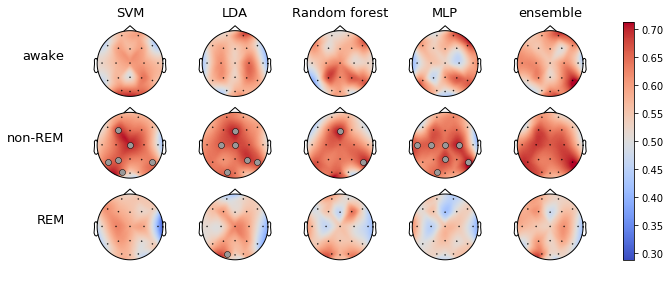

In [6]:
colormap = 'coolwarm'
small_font = 13
big_font = 20

vmin = np.min([[[np.min(da_scores[stage][clf][elec][0]) for elec in range(20)] for clf in da_scores[stage].keys()] for stage in STAGES])
vmax = np.max([[[np.max(da_scores[stage][clf][elec][0]) for elec in range(20)] for clf in da_scores[stage].keys()] for stage in STAGES])

for stage in STAGES:
    print(stage, np.max([[np.max(da_scores[stage][clf][elec][0]) for elec in range(20)] for clf in da_scores[stage].keys()]))

diff = max(abs(0.5 - vmin), abs(0.5 - vmax))
vmin = 0.5 - diff
vmax = 0.5 + diff

plt.figure(figsize=(12, 4))

subplot_counter = 0
gs = gridspec.GridSpec(len(STAGES),
                       len(da_scores[stage]) + 1,
                       width_ratios=[0.1] + [1] * len(da_scores[stage]),
                       wspace=0,
                       hspace=0.1)
annotations = []
axes = []
for stage in STAGES:
    plt.subplot(gs[subplot_counter])
    annotations.append(plt.annotate(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'), xy=(1, 0.5), fontsize=small_font, ha='right'))
    plt.axis('off')
    subplot_counter += 1
    
    for clf in da_scores[stage].keys():
        acc = [score[0] for score in da_scores[stage][clf]]
        p_val = np.array([score[1] for score in da_scores[stage][clf]])
        
        #mask = p_val < SIGNIFICANT_P # not corrected
        mask = p_val <= (1 / p_val.shape[0] * SIGNIFICANT_P) # corrected with Bonferroni
        
        marker_colors = [[0.6, 0.6, 0.6]] * len(mask)
        #for i in np.where(p_val < SIGNIFICANT_P_STRONG)[0]: # not corrected
        for i in np.where(p_val <= (1 / p_val.shape[0] * SIGNIFICANT_P_STRONG))[0]: # corrected with Bonferroni method
            marker_colors[i] = STRONG_SIGNIFICANCE_COLOR
        marker_colors = np.array(marker_colors)[mask]
        
        axes.append(plt.subplot(gs[subplot_counter]))
        
        if stage == STAGES[0]:
            plt.title(clf.replace('MultilayerPerceptron', 'MLP').replace('RandomForest', 'Random forest'), fontsize=small_font)
        
        viz.plot_topomap(acc,
                         sensor_pos,
                         mask=mask,
                         vmin=vmin,
                         vmax=vmax,
                         cmap=colormap,
                         mask_params={'markersize': 6, 'markeredgewidth': 0.5, 'markerfacecolor': marker_colors},
                         contours=False,
                         show=False)
        subplot_counter += 1

norm = colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=axes, shrink=1, aspect=20)

plt.savefig(os.path.join(FIGURE_PATH, 'decodingAccuracyMulti', f'decodingAccuracy{CAF_DOSE}'),
            bbox_inches='tight',
            bbox_extra_artists=annotations,
            transparent=True,
            dpi=200)
plt.show()